### 1.导入需要的库

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### 2.导入数据、检查数据

In [56]:
# 载入数据
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
print('data shape: {0}; no. positive: {1}; no. negative: {2}'.format(
    X.shape, y[y==1].shape[0], y[y==0].shape[0]))
#print(cancer.data[0])

data shape: (569, 30); no. positive: 357; no. negative: 212


In [57]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

### 3.数据分割、建立模型、模型学习及评估

#### 1）数据分割

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 2）模型建立、学习、评估


In [59]:
from sklearn.linear_model import LogisticRegression
#模型建立
model = LogisticRegression(solver='liblinear')
#模型学习
model.fit(X_train, y_train)
#模型评估
#score: classification accuracy
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('train score: {train_score:.6f};\ntest score: {test_score:.6f}'.format(
    train_score=train_score, test_score=test_score))

train score: 0.953846;
test score: 0.938596


In [60]:
# 样本预测
y_pred = model.predict(X_test)
print('match: {0}/{1}'.format(np.sum(np.equal(y_pred,y_test)),y_test.shape[0]))

match: 107/114


In [61]:
# 预测概率：找出低于概率90% 的样本个数
y_pred_proba = model.predict_proba(X_test)
print('sample of predict probability: {0}'.format(y_pred_proba[0]))
print(y_pred_proba[(y_pred_proba[:,0]<0.9) & (y_pred_proba[:,1]<0.9)])

sample of predict probability: [1.0000000e+00 6.2357714e-11]
[[0.21555604 0.78444396]
 [0.12798212 0.87201788]
 [0.24206101 0.75793899]
 [0.85928179 0.14071821]
 [0.89453238 0.10546762]
 [0.88634267 0.11365733]
 [0.13351111 0.86648889]
 [0.2591514  0.7408486 ]
 [0.15321785 0.84678215]
 [0.61808246 0.38191754]
 [0.55708255 0.44291745]
 [0.54609818 0.45390182]
 [0.14933095 0.85066905]
 [0.11227668 0.88772332]]


#### 3）多项式特征

In [62]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# 增加多项式预处理，**
def polynomial_model(degree=1, **kwarg):
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    logistic_regression = LogisticRegression(**kwarg,solver='liblinear',max_iter=200)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("logistic_regression", logistic_regression)])
    return pipeline
#模型建立，采用L1正则化处理
model = polynomial_model(degree=2, penalty='l1')
#模型训练
start = time.time()
model.fit(X_train, y_train)
#模型评估，指标为准确率
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('elaspe time: {0:.6f};\ntrain_score: {1:0.6f};\ntest_score: {2:.6f}'.format(
    time.time()-start, train_score, test_score))

elaspe time: 0.410489;
train_score: 1.000000;
test_score: 0.973684


In [63]:
#**kwargs
def test_func(**kwargs):
    print(type(kwargs))
    print(kwargs)
    
test_func(a=5,b=4)

<class 'dict'>
{'a': 5, 'b': 4}


In [64]:
#单独查看分类模型
logistic_regression = model.named_steps['logistic_regression']
print('model parameters shape: {0}; count of non-zero element: {1}'.format(
    logistic_regression.coef_.shape, 
    np.count_nonzero(logistic_regression.coef_)))

model parameters shape: (1, 495); count of non-zero element: 82


#### 4）多项式次数及正则化方式的影响

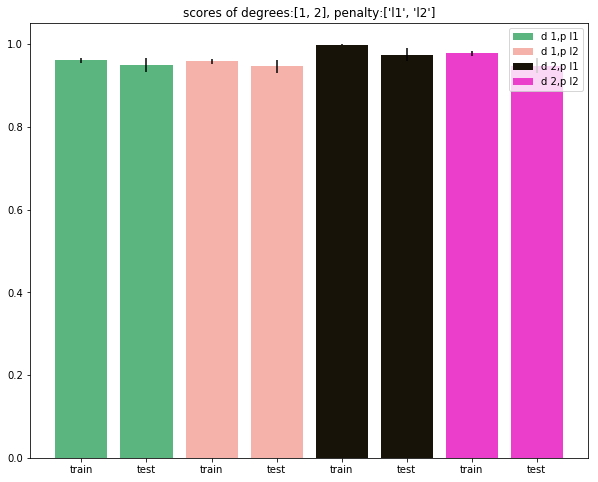

In [65]:
#from common.utils import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
#数据分割
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=0)
#多项式次数及正则化方式
degrees=[1,2]
penalty=['l1','l2']
title='scores of degrees:{}, penalty:{}'.format(degrees,penalty)
plt.figure(figsize=(10,8))
#验证不同多项式次数、正则化方式组合的效果
for i in range(len(degrees)):
    for j in range(len(penalty)):
        poly=polynomial_model(degree=degrees[i],penalty=penalty[j])
        train_scores=[]
        test_scores=[]
        for train,test in cv.split(X):
            poly.fit(X[train],y[train])
            train_scores.append(poly.score(X[train],y[train]))
            test_scores.append(poly.score(X[test],y[test]))
        train_mean=np.mean(train_scores)
        train_std=np.std(train_scores)
        test_mean=np.mean(test_scores)
        test_std=np.std(test_scores)
        plt.bar([i*len(penalty)*2+2*j,i*len(penalty)*2+2*j+1],[train_mean,test_mean],width=0.8,yerr=[train_std,test_std],color=np.random.rand(1,3),label='d %d,p %s'%(degrees[i],penalty[j]))

        #plt.bar([2*i+4*j,2*i+4*j+1],[train_mean,test_mean],width=0.8,yerr=[train_std,test_std],color=np.random.rand(1,3))
plt.xticks(np.arange(len(degrees)*len(penalty)*2),['train','test']*(len(degrees)*len(penalty)))
plt.legend()
plt.title(title)
plt.show()

